In [1]:
# Common imports and settings
import os, sys, re
from pathlib import Path
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr
import dask
from dask.distributed import Client
from dask_gateway import Gateway
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

# Datacube
import datacube
from datacube.utils.aws import configure_s3_access
import odc.geo.xr                                  # https://github.com/opendatacube/odc-geo
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool                  # https://github.com/opendatacube/odc-tools/blob/develop/libs/algo/odc/algo/_masking.py
from dea_tools.plotting import display_map, rgb    # https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools

import boto3

# Basic plots
%matplotlib inline
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Holoviews
# https://holoviz.org/tutorial/Composing_Plots.html
# https://holoviews.org/user_guide/Composing_Elements.html
import hvplot.pandas
import hvplot.xarray
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
# hv.extension('bokeh', logo=False)
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
# EASI defaults
# These are convenience functions so that the notebooks in this repository work in all EASI deployments

# The `git.Repo()` part returns the local directory that easi-notebooks has been cloned into
# If using the `easi-tools` functions from another path, replace `repo` with your local path to `easi-notebooks` directory
try:
    import git
    repo = git.Repo('.', search_parent_directories=True).working_tree_dir    # Path to this cloned local directory
except (ImportError, git.InvalidGitRepositoryError):
    repo = Path.home() / 'easi-notebooks'    # Reasonable default
    if not repo.is_dir():
        raise RuntimeError('To use `easi-tools` please provide the local path to `https://github.com/csiro-easi/easi-notebooks`')
if repo not in sys.path:
    sys.path.append(str(repo))    # Add the local path to `easi-notebooks` to python

from easi_tools import EasiDefaults
from easi_tools import initialize_dask, xarray_object_size, mostcommon_crs, heading
#from easi_tools.load_s2l2a import load_s2l2a_with_offset
print("EASI librariies loaded successfully.")

EASI librariies loaded successfully.


# Dataprep with Dask
Goals:
- query and prep data
- Load in and save data into user scratch or some other spot

In [5]:
client.close()
cluster.shutdown()

In [3]:
# 1. Get EASI Defaults
easi = EasiDefaults()
bucket = easi.scratch

# 2. Get User ID
userid = boto3.client('sts').get_caller_identity()['UserId']

# 3. Define your Project Name and Dataset Name
project_name = "traning_test_project"
dataset_name = "training_dataset_v1.zarr"

# 4. Construct the full S3 Path
# This is where Dask will write the files
s3_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"

print(f"Target Storage Path: {s3_path}")

Successfully found configuration for deployment "csiro"
Target Storage Path: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/traning_test_project/training_dataset_v1.zarr


For stuff like loading in data, we don't need GPUs yet so this should be ok

In [4]:
gateway = Gateway()
options = gateway.cluster_options()

clusters = gateway.list_clusters()
if not clusters:
    print('Creating new cluster...')
    cluster = gateway.new_cluster(cluster_options=options)
else:
    print(f'Connecting to existing cluster: {clusters[0].name}')
    cluster = gateway.connect(clusters[0].name)


cluster.scale(4)
client = cluster.get_client()

print("Cluster Dashboard:", client.dashboard_link)


Creating new cluster...
Cluster Dashboard: https://hub.csiro.easi-eo.solutions/services/dask-gateway/clusters/easihub.c4ec14863c20433f81d7e854b45652e4/status


Task exception was never retrieved
future: <Task finished name='Task-3148' coro=<Client._gather.<locals>.wait() done, defined at /env/lib/python3.12/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/env/lib/python3.12/site-packages/distributed/client.py", line 2394, in wait
    raise AllExit()
distributed.client.AllExit


In [7]:
from pystac_client import Client as StacClient

In [5]:
# from datacube.utils.masking import describe_variable_flags

# # # Print the available flags for the fmask band
# # import pandas as pd

# # # Show all rows and columns
# # pd.set_option("display.max_rows", None)
# # pd.set_option("display.max_columns", None)
# # pd.set_option("display.width", None)
# # pd.set_option("display.max_colwidth", None)

# # # Now print the flags
# # describe_variable_flags(ds.fmask)
dc = datacube.Datacube()
# So workers can access AWS
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

In [ ]:
import planetary_computer
from pystac_client import Client as PClient
import odc.stac
import boto3
import dask
from easi_tools import EasiDefaults
import warnings
warnings.filterwarnings('ignore')
from odc.geo.geobox import GeoBox
from odc.geo.geom import box as odc_box


# === S3 SETUP ===
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
dataset_name = "training_dataset_v3.zarr"
s3_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"
print(f"Target Storage Path: {s3_path}")

# === CONFIGURATION ===
locations = {
    "tasmania_forest":   [146.5, -42.0, 146.7, -41.8],
    "vic_agriculture":   [143.5, -37.0, 143.7, -36.8],
    "nsw_coast":         [150.8, -34.5, 151.0, -34.3],
    "qld_tropical":      [145.7, -16.5, 145.9, -16.3],
    "wa_arid":           [116.0, -32.0, 116.2, -31.8]
}

seasonal_windows = [
    "2021-01-01/2021-02-28",
    "2021-06-01/2021-07-31",
    "2021-09-01/2021-10-31"
]

bands_s2 = ["B02", "B03", "B04", "B8A", "B11", "B12", "SCL"]
band_names = ["blue", "green", "red", "nir", "swir1", "swir2"]

resolution = 20
output_crs = "EPSG:3577"

catalog = PClient.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)



#   PROCESS ONE LOCATION 
def process_location(loc_name, bbox):
    try:
        # === 1. Create a Fixed Target Grid (GeoBox) ===
        # We must force every sample to have identical pixel dimensions (e.g., 1024x1024).
        # If we rely on 'resolution=20', the pixel width changes with latitude, breaking the stack.
        
        # Create a polygon from the Lat/Lon bbox
        geom_4326 = odc_box(bbox[0], bbox[1], bbox[2], bbox[3], crs="EPSG:4326")
        
        # Project it to your output CRS (EPSG:3577)
        geom_3577 = geom_4326.to_crs(output_crs)
        
        # Create a GeoBox that fits this area into exactly 1024x1024 pixels
        # This essentially sets a dynamic resolution close to 20m, but enforces exact shape.
        geobox = GeoBox.from_bbox(
            geom_3577.boundingbox, 
            crs=output_crs, 
            shape=(224, 224) 
        )

        # -- Load labels --
        label_items = catalog.search(
            collections=["esa-worldcover"],
            bbox=bbox
        ).item_collection()

        # NOTE: We use 'geobox=geobox' instead of 'bbox' and 'resolution'
        labels = odc.stac.load(
            label_items,
            bands=["map"],
            geobox=geobox,      # <--- FORCE FIXED GEOMETRY
            chunks={"x": 512, "y": 512},
            resampling="nearest",
            fail_on_error=False
        )
        
        # Load seasonal
        composites = []

        for time_range in seasonal_windows:
            s2_items = catalog.search(
                collections=["sentinel-2-l2a"],
                bbox=bbox,
                datetime=time_range,
                query={"eo:cloud_cover": {"lt": 90}}
            ).item_collection()

            if not s2_items:
                return None

            ds = odc.stac.load(
                s2_items,
                bands=bands_s2,
                geobox=geobox,  # <--- MATCH LABEL GEOMETRY EXACTLY
                chunks={"x": 512, "y": 512},
                fail_on_error=False
            )

            # Skip empty results
            if ds.sizes.get("time", 0) == 0:
                return None

            # Cloud-clean composite
            if "SCL" in ds:
                qa = ds["SCL"]
                valid = (qa == 4) | (qa == 5) | (qa == 6) | (qa == 7) | (qa == 2) | (qa == 11)
                masked = ds.where(valid)
                comp = masked.median(dim="time")
                comp = comp.fillna(masked.min(dim="time")).fillna(0)
            else:
                comp = ds.median(dim="time").fillna(0)

            composites.append(comp)

        if len(composites) != 3:
            return None

        stacked = xr.concat(composites, dim="time")

        # Select only bands needed
        features = stacked[["B02", "B03", "B04", "B8A", "B11", "B12"]]
        features = features.rename({
            "B02": "blue",
            "B03": "green",
            "B04": "red",
            "B8A": "nir",
            "B11": "swir1",
            "B12": "swir2"
        })

        features = features.astype("uint16")
        features = features.to_array(dim="band").transpose("band", "time", "y", "x")

        labels_da = labels["map"].isel(time=0, drop=True)
        labels_da = labels_da.fillna(255).astype("uint8")

        return xr.Dataset({
            "features": features,
            "labels": labels_da
        })

    except Exception as e:
        print(f"[{loc_name}] ERROR: {e}")
        return None


print("\nBuilding computation graph...")

lazy = []
for loc_name, bbox in locations.items():
    print(f"  Adding: {loc_name}")
    lazy.append(dask.delayed(process_location)(loc_name, bbox))



#   EXECUTE
print("\nExecuting distributed jobs...")
results = dask.compute(*lazy)

valid = [ds for ds in results if ds is not None]

print(f"Processed {len(valid)} / {len(locations)}")

if not valid:
    raise RuntimeError("No valid samples produced.")



#   COMBINE SAMPLES
combined = []

for i, ds in enumerate(valid):
    ds = ds.assign_coords(
        x=np.arange(ds.sizes['x']),
        y=np.arange(ds.sizes['y'])
    )
    # Drop specific map-related attributes if they persist
    ds = ds.drop_vars(['spatial_ref', 'crs'], errors='ignore')
    ds = ds.expand_dims(sample=[i])# fix: sample is NEW dimension
    combined.append(ds)

ds_final = xr.concat(combined, dim="sample")

# Recommended chunking for DL + Prithvi chunck requirements
ds_final = ds_final.chunk({
    "sample": 1,
    "time": -1,
    "band": -1,
    "y": 224,
    "x": 224
})

# Metadata
ds_final.attrs["n_samples"] = len(valid)
ds_final.attrs["n_time_steps"] = 3
ds_final.attrs["bands"] = band_names

print("\nFinal dataset:")
print(ds_final)

#   SAVE TO ZARR
print(f"Writing to: {s3_path}")
ds_final.to_zarr(s3_path, mode="w", consolidated=True)

print("\n[DONE]")


In [7]:
# Get the centroid of the coordinates of the default extents
central_lat = sum(easi.latitude)/2
central_lon = sum(easi.longitude)/2
# central_lat = -42.019
# central_lon = 146.615

# Set the buffer to load around the central coordinates
# This is a radial distance for the bbox to actual area so bbox 2x buffer in both dimensions
buffer = 0.8

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

# Data product
products = easi.product('landsat')

# Set the date range to load data over
set_time = easi.time
set_time = (set_time[0], parse(set_time[0]) + relativedelta(years=1))
# set_time = ("2021-01-01", "2021-12-31")

# ------------------------ Measurment choice -----------------
# Selected measurement names (used in this notebook). None` will load all of them
alias = easi.aliases('landsat')
#all_measurements = list(alias.values())
#print(f"{alias.keys()}")

target_keys = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']


spectral_measurements = [alias[k] for k in target_keys]
#measurements = [alias['red'], alias['green'], alias['blue'], qa_band]
# measurements = [alias[x] for x in ['qa_band', 'red', 'nir']]

# Set the QA band name and mask values
qa_band = alias['qa_band']
qa_mask = easi.qa_mask('landsat')

measurements = spectral_measurements + [qa_band]

# Set the resampling method for the bands
resampling = {qa_band: "nearest", "*": "average"}

# Set the coordinate reference system and output resolution
set_crs = easi.crs('landsat')  # If defined, else None
set_resolution = easi.resolution('landsat')  # If defined, else None
# set_crs = "epsg:3577"
# set_resolution = (-30, 30)

# Set the scene group_by method
group_by = "solar_day"

In [8]:
label_product = 'ga_ls_landcover_class_cyear_3'
label_measurement = 'level3'

dataset = None # clear results from any previous runs
dataset = dc.load(
            product=products,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling=resampling,
            output_crs=set_crs,
            resolution=set_resolution,
            dask_chunks = {"time":1, "x":2048, "y":2048},
            group_by=group_by,
        )
print(f"dataset size (GiB) {dataset.nbytes / 2**30:.2f}")
# --- NEW: LOAD AND ALIGN LABELS ---

# 1. Load label data broadly using the initial time range (required by dc.load)
labels_broad_ds = dc.load(
    product=label_product,
    x=study_area_lon,
    y=study_area_lat,
    time=set_time, # Must use start/end date format
    measurements=[label_measurement],
    resampling={"*": "nearest"}, # Labels must use nearest neighbor resampling
    output_crs=set_crs,
    resolution=set_resolution,
    dask_chunks = {"time":1, "x":2048, "y":2048}, # Use same I/O chunking
    group_by=group_by,
)

# 2. Align labels onto the exact time dimension of the Landsat input
labels_ds = labels_broad_ds.reindex_like(
    dataset, 
    method='nearest' # Force alignment to nearest composite map time
)

print(f"Label data successfully aligned. Total scenes: {labels_ds.time.size}")


# Identify pixels that are either "valid", "water" or "snow"
cloud_free_mask = masking.make_mask(dataset[qa_band], **qa_mask)
# Separate the bands we want to TRAIN on (RGB)
# Drop the QA band now, we don't feed it to the model.
training_ds = dataset[spectral_measurements]

# Apply Mask: Use , 0 to replace clouds with Black. 
# Default .where() creates NaNs, which break PyTorch.
ds_masked = training_ds.where(cloud_free_mask, 0)


# Landsat is Int16 (0-10,000). Normalize to Float32 (0-1).
ds_norm = ds_masked.astype('float32') / 10000.0

# Convert Dictionary (Dataset) to Block (DataArray)
# This stacks Red/Green/Blue into a new dimension 'band'
ds_final = ds_norm.to_array(dim='band')

# 1. Extract the aligned label array
labels_da = labels_ds[label_measurement]

# Inspect nodata value if present
print("Label attrs:", labels_da.attrs)
print("Label encoding:", labels_da.encoding)

# 2. Map nodata (if any) to 255, but DO NOT apply the Landsat cloud mask
nodata = labels_da.attrs.get("nodata", None)
if nodata is None:
    nodata = labels_da.encoding.get("_FillValue", None)

if nodata is not None:
    labels_clean = labels_da.where(labels_da != nodata, 255)
else:
    labels_clean = labels_da  # assume all values are valid classes

# 3. Convert to final format (Int64 is required for PyTorch class indices)
labels_final = labels_clean.astype("int64")
training_ds_combined = xr.Dataset(
    {
        'features': ds_final,
        'labels': labels_final
    }
)

# Rechunk for Training
ds_final = training_ds_combined.chunk({'time': 1, 'x': 224, 'y': 224})

print("Data Pipeline Ready:")
ds_final

dataset size (GiB) 18.34
Label data successfully aligned. Total scenes: 43
Label attrs: {'units': '1', 'nodata': 255, 'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'}
Label encoding: {}
Data Pipeline Ready:


<xarray.Dataset> Size: 48GB
Dimensions:      (time: 43, y: 6441, x: 5469, band: 6)
Coordinates:
  * time         (time) datetime64[ns] 344B 2020-02-08T23:56:31.774346 ... 20...
  * y            (y) float64 52kB -3.922e+06 -3.922e+06 ... -4.115e+06
  * x            (x) float64 44kB 1.272e+06 1.272e+06 ... 1.436e+06 1.436e+06
    spatial_ref  int32 4B 3577
  * band         (band) object 48B 'nbart_blue' 'nbart_green' ... 'nbart_swir_2'
Data variables:
    features     (band, time, y, x) float32 36GB dask.array<chunksize=(1, 1, 224, 224), meta=np.ndarray>
    labels       (time, y, x) int64 12GB dask.array<chunksize=(1, 224, 224), meta=np.ndarray>

In [20]:
import planetary_computer
# Your specific area & time
bbox = [145.815, -42.819, 147.415, -41.219] # Central Tasmania
time_range = "2021-01-01/2021-12-31"

# --- 2. SEARCH (STAC) ---
catalog = StacClient.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace # SIGN ITEMS AUTOMATICALLY
)

print("Searching for Sentinel-2 L2A...")
s2_items = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=time_range,
    # Filter for low cloud cover to avoid garbage data
    query={"eo:cloud_cover": {"lt": 50}} 
).item_collection()

print(f"Found {len(s2_items)} Sentinel-2 scenes.")

print("Searching for WorldCover...")
label_items = catalog.search(
    collections=["esa-worldcover"],
    bbox=bbox
).item_collection()

# --- 3. LOAD & ALIGN ---

# Band Mapping for Prithvi (S2 L2A names on MPC)
# Note: 'SCL' is the Scene Classification Layer (like 'qa')
bands_s2 = {
    "B02": "blue", 
    "B03": "green", 
    "B04": "red", 
    "B8A": "nir",   # Use B8A (Narrow NIR) for Prithvi consistency
    "B11": "swir1", 
    "B12": "swir2", 
    "SCL": "qa"     # Sentinel Classification Layer
}

# Config: Sentinel-2 is 10m/20m/60m. Prithvi wants 30m (HLS) but works fine at 20m.
# Let's load at 20m resolution (standard for S2 SWIR bands).
resolution = 20 
crs = "EPSG:32755" # UTM Zone 55S (Native for Tasmania) OR "EPSG:3577" (Albers)

# A. Load Imagery
ds = odc.stac.load(
    s2_items,
    bands=bands_s2,
    bbox=bbox,
    chunks={"x": 2048, "y": 2048, "time": 1},
    resolution=resolution,
    crs=crs,
    groupby="solar_day",
    fail_on_error=False,
    # MPC Patching is usually handled by 'planetary_computer' modifier above
)

# B. Load Labels (Aligned to S2 grid)
labels = odc.stac.load(
    label_items,
    bands=["map"],
    geobox=ds.odc.geobox, # Force alignment
    chunks={"x": 2048, "y": 2048, "time": 1},
    resampling="nearest",
    fail_on_error=False
)

# --- 4. PRE-PROCESS (Offset & Masking) ---

# Sentinel-2 L2A on MPC is already offset-corrected in metadata, 
# but let's ensure we get float reflectance (0.0 - 1.0).
# SCL Mask: 0=NoData, 1=Saturated, 3=Cloud Shadow, 8-10=Cloud/Cirrus
# Valid Land: 4, 5, 6, 7 (Veg, Bare, Water, Unclassified)
# We mask out clouds (values 3, 8, 9, 10)
qa = ds['SCL']
valid_mask = (qa == 4) | (qa == 5) | (qa == 6) | (qa == 7)

# Normalize: S2 data is typically UInt16 (0-10000).
# Prithvi expects 0-1 float.
# 1. Normalize and Create Features Stack
features = ds[['B02', 'B03', 'B04', 'B8A', 'B11', 'B12']].where(valid_mask, 0)
features = features.rename({
    'B02': 'blue',
    'B03': 'green',
    'B04': 'red',
    'B8A': 'nir',
    'B11': 'swir1',
    'B12': 'swir2'
})
features = features.astype("float32") / 10000.0 

# Stack into (band, time, y, x)
features_stack = features.to_array(dim="band", name="features")

# 2. Broadcast Labels (Using a band that definitely exists in 'ds')
# We use 'B02' because 'blue' does not exist in 'ds'.
# Alternatively, we could use features['blue'] which DOES exist.
labels_map = labels['map'].isel(time=0, drop=True)
labels_expanded = labels['map'].broadcast_like(ds['B02']) # <--- FIXED: used 'B02' instead of 'blue'

# 3. Combine
# Note: features_stack is already a DataArray, so we don't call to_array() again inside Dataset
train_ds = xr.Dataset({
    "features": features_stack,
    "labels": labels_expanded
}).chunk({"x": 1024, "y": 1024, "time": 1})

print(f"Pipeline Ready. Size: {train_ds.nbytes / 1e9:.2f} GB")

Searching for Sentinel-2 L2A...
Found 503 Sentinel-2 scenes.
Searching for WorldCover...
Pipeline Ready. Size: 197.51 GB


In [10]:
client.restart()

In [11]:
import planetary_computer
from pystac_client import Client
import odc.stac
import xarray as xr
import numpy as np
import boto3
import dask
from dask_gateway import Gateway
from easi_tools import EasiDefaults


# --- S3 SETUP ---
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
dataset_name = "training_dataset_v1.zarr"
s3_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"
print(f"Target Storage Path: {s3_path}")

# --- CONFIGURATION ---
locations = {
    "tasmania_forest":   [146.5, -42.0, 146.7, -41.8],
    "vic_agriculture":   [143.5, -37.0, 143.7, -36.8],
    "nsw_coast":         [150.8, -34.5, 151.0, -34.3],
    "qld_tropical":      [145.7, -16.5, 145.9, -16.3],
    "wa_arid":           [116.0, -32.0, 116.2, -31.8]
}

seasonal_windows = [
    "2021-01-01/2021-02-28",
    "2021-06-01/2021-07-31",
    "2021-09-01/2021-10-31"
]

bands_s2 = ["B02", "B03", "B04", "B8A", "B11", "B12", "SCL"]
band_names = ["blue", "green", "red", "nir", "swir1", "swir2"]
resolution = 20
output_crs = "EPSG:3577"

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)


def process_location(loc_name, bbox):
    """Process a single location - runs on distributed workers."""
    
    try:
        # Load labels
        label_items = catalog.search(
            collections=["esa-worldcover"], 
            bbox=bbox
        ).item_collection()
        
        labels = odc.stac.load(
            label_items, 
            bands=["map"], 
            bbox=bbox, 
            chunks={"x": 512, "y": 512},
            resolution=resolution, 
            crs=output_crs, 
            resampling="nearest", 
            fail_on_error=False
        )
        target_geobox = labels.odc.geobox
        
        # Load each time step
        time_steps = []
        
        for time_range in seasonal_windows:
            s2_items = catalog.search(
                collections=["sentinel-2-l2a"], 
                bbox=bbox, 
                datetime=time_range,
                query={"eo:cloud_cover": {"lt": 90}} 
            ).item_collection()
            
            if not s2_items:
                return None

            ds = odc.stac.load(
                s2_items,
                bands=bands_s2,
                geobox=target_geobox,
                chunks={"x": 512, "y": 512},
                fail_on_error=False
            )
            
            if ds.sizes['time'] == 0:
                return None
            
            # Cloud-free composite (stays lazy)
            if 'SCL' in ds:
                qa = ds['SCL']
                valid_mask = (qa == 4) | (qa == 5) | (qa == 6) | (qa == 7) | (qa == 2) | (qa == 11)
                ds_masked = ds.where(valid_mask)
                composite = ds_masked.median(dim="time")
                fallback = ds.min(dim="time")
                composite = composite.fillna(fallback).fillna(0)
            else:
                composite = ds.median(dim="time").fillna(0)
            
            time_steps.append(composite)

        if len(time_steps) != 3:
            return None

        # Stack time steps
        stacked = xr.concat(time_steps, dim="time")
        
        features = stacked[["B02", "B03", "B04", "B8A", "B11", "B12"]]
        features = features.rename({
            'B02': 'blue', 'B03': 'green', 'B04': 'red',
            'B8A': 'nir', 'B11': 'swir1', 'B12': 'swir2'
        })
        features = features.astype("float32") / 10000.0
        features_da = features.to_array(dim="band").transpose("time", "band", "y", "x")
        
        labels_da = labels['map'].isel(time=0, drop=True)
        
        return xr.Dataset({
            "features": features_da,
            "labels": labels_da
        })
        
    except Exception as e:
        print(f"Error processing {loc_name}: {e}")
        return None


# --- BUILD LAZY COMPUTATION GRAPH ---
print("\nBuilding computation graph...")

lazy_datasets = []
for loc_name, bbox in locations.items():
    print(f"  Adding: {loc_name}")
    ds = dask.delayed(process_location)(loc_name, bbox)
    lazy_datasets.append(ds)

# --- EXECUTE ON DISTRIBUTED WORKERS ---
print("\nExecuting on distributed workers...")
print("(Watch progress on dashboard)")

results = dask.compute(*lazy_datasets)

# Filter failures
valid_datasets = [ds for ds in results if ds is not None]
print(f"\nProcessed: {len(valid_datasets)}/{len(locations)} locations")

if not valid_datasets:
    raise RuntimeError("No valid datasets!")

# --- COMBINE ---
print("\nCombining samples...")

for i, ds in enumerate(valid_datasets):
    valid_datasets[i] = ds.expand_dims({"sample": [i]})

ds_final = xr.concat(valid_datasets, dim="sample")

ds_final = ds_final.chunk({
    "sample": 1,
    "time": -1,
    "band": -1,
    "y": 224,
    "x": 224
})

ds_final.attrs["n_samples"] = len(valid_datasets)
ds_final.attrs["n_time_steps"] = 3
ds_final.attrs["bands"] = band_names

print(f"\nDataset structure:")
print(f"  features: {dict(ds_final['features'].sizes)}")
print(f"  labels:   {dict(ds_final['labels'].sizes)}")

# --- SAVE TO S3 ---
print(f"\nWriting to {s3_path}...")
ds_final.to_zarr(s3_path, mode='w', consolidated=True)

print(f"\n[DONE] Saved to S3.")
print("Pipeline complete.")

Successfully found configuration for deployment "csiro"
Target Storage Path: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v1.zarr

Building computation graph...
  Adding: tasmania_forest
  Adding: vic_agriculture
  Adding: nsw_coast
  Adding: qld_tropical
  Adding: wa_arid

Executing on distributed workers...
(Watch progress on dashboard)

Processed: 5/5 locations

Combining samples...


/tmp/ipykernel_105/3573861579.py:161: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  ds_final = xr.concat(valid_datasets, dim="sample")
/tmp/ipykernel_105/3573861579.py:161: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  ds_final = xr.concat(valid_datasets, dim="sample")
/env/lib/python3.12/site-packages/dask/array/core.py:5003: PerformanceWarning: Increasing number of ch


Dataset structure:
  features: {'sample': 5, 'time': 3, 'band': 6, 'y': 6036, 'x': 5288}
  labels:   {'sample': 5, 'y': 6036, 'x': 5288}

Writing to s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v1.zarr...


/env/lib/python3.12/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/env/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 151.64 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(



[DONE] Saved to S3.
Pipeline complete.


In [15]:
# Fixed an error in the Zar encoding, time already has units or something i guess?
#train_ds.time.attrs.pop('units', None)

task = train_ds.to_zarr(s3_path, mode='w', consolidated=True, compute=False)

print("Graph built. Submitting to cluster...")

dask.compute(task)



/env/lib/python3.12/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Graph built. Submitting to cluster...


/env/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 44.65 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(None,)

In [9]:
# Check
ds = xr.open_dataset(s3_path, engine='zarr')
print(ds)

<xarray.Dataset> Size: 198GB
Dimensions:      (band: 6, time: 118, y: 8913, x: 6707)
Coordinates:
  * band         (band) object 48B 'blue' 'green' 'red' 'nir' 'swir1' 'swir2'
    spatial_ref  int32 4B ...
  * time         (time) datetime64[ns] 944B 2020-01-01 ... 2021-12-30T00:02:4...
  * x            (x) float64 54kB 4.007e+05 4.007e+05 ... 5.348e+05 5.348e+05
  * y            (y) float64 71kB 5.437e+06 5.437e+06 ... 5.259e+06 5.259e+06
Data variables:
    features     (band, time, y, x) float32 169GB ...
    labels       (time, y, x) float32 28GB ...


⏳ Verifying Saved Data at: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v1.zarr
Dataset loaded. Dimensions:
  Samples (N): 5
  Time Steps (T): 3
  Spatial (Y, X): 6036, 5288
  Bands: ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
Processing Sample 0...
Processing Sample 1...
Processing Sample 2...
Processing Sample 3...
Processing Sample 4...


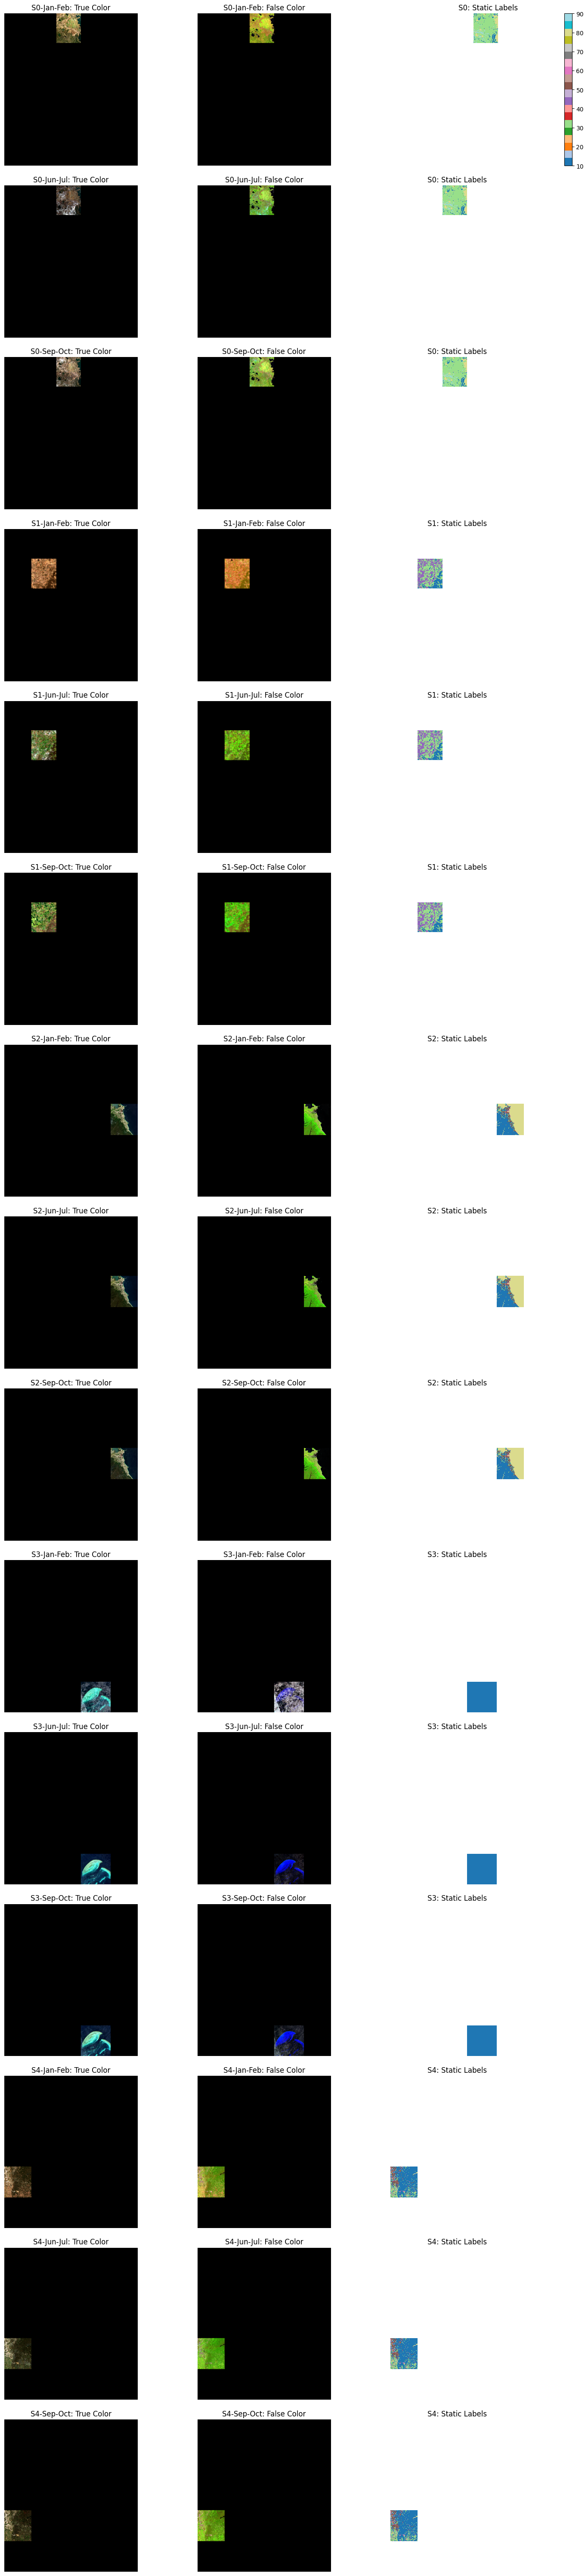

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import dask.distributed

# --- CONFIGURATION ---
# The s3_path from the saving notebook should be used here.
# Example: s3_zarr_path = s3_path
s3_zarr_path = s3_path # Ensure this variable is accessible/set

print(f"⏳ Verifying Saved Data at: {s3_zarr_path}")

# --- 1. Load Data (Distributively if needed) ---
# Use Dask for loading to match the environment, although 'chunks={}' will load
# the metadata and index the chunks for all workers.
try:
    # Set up S3 access
    fs = s3fs.S3FileSystem()
    store = s3fs.S3Map(root=s3_zarr_path, s3=fs, check=False)
    
    # Open the multi-sample Zarr store. 'chunks={}' loads the full dataset chunks
    # lazily without combining them into a single dask chunk.
    ds = xr.open_dataset(store, engine='zarr', chunks={}) 
except Exception as e:
    print(f"⚠️ Error loading Zarr: {e}")
    raise

features = ds['features']
labels = ds['labels']

num_samples = features.sizes['sample'] # Check the new 'sample' dimension size
n_time_steps = features.sizes['time']  # Check the 'time' dimension size
print(f"Dataset loaded. Dimensions:")
print(f"  Samples (N): {num_samples}")
print(f"  Time Steps (T): {n_time_steps}")
print(f"  Spatial (Y, X): {features.sizes['y']}, {features.sizes['x']}")

# --- 2. Config & Helpers ---
# Band names are now coordinates thanks to the saving logic
band_names = ds.attrs["bands"] # Retrieve band names from dataset attributes
print(f"  Bands: {band_names}")

def get_rgb(data_array, bands_list):
    """
    Extracts bands for RGB from a DataArray, assuming 'band' is a dimension.
    Input data_array is expected to be (T, B, Y, X)
    """
    stack = []
    for b in bands_list:
        # Select band across all time steps
        band_data = data_array.sel(band=b) 
        stack.append(band_data)
        
    # Stack along a new 'color' dimension, then transpose to (T, Y, X, Color)
    img = xr.concat(stack, dim="color").transpose('time', 'y', 'x', 'color').values.astype('float32')
    img = np.nan_to_num(img, nan=0.0)
    
    # Check if all images are empty (all zeros)
    if img.max() == 0:
        return None # Signal that all images in this sample are invalid
        
    # Contrast Stretch - apply stretching to each time step independently
    for t in range(img.shape[0]):
        time_slice = img[t, :, :, :]
        valid_pixels = time_slice[time_slice > 0]
        if valid_pixels.size > 0:
            p2, p98 = np.percentile(valid_pixels, (2, 98))
            if p98 > p2:
                img[t, :, :, :] = (time_slice - p2) / (p98 - p2)
                
    return np.clip(img, 0, 1)

# --- 3. Dynamic Plotting Loop ---

# Iterate over SAMPLES, not time steps.
rows = num_samples * n_time_steps 
cols = 3 # RGB, False Color, Labels

plt.figure(figsize=(15, 4 * rows))

plot_idx = 1
season_names = ["Jan-Feb", "Jun-Jul", "Sep-Oct"] # Names from seasonal_windows

for s in range(num_samples):
    # Select a single sample and compute its features and label.
    # .compute() here will read data off S3, potentially distributively if
    # the dask client is still running, which is appropriate for verification.
    sample_features = features.isel(sample=s).compute()
    sample_label = labels.isel(sample=s).compute()
    
    # Check for valid data across all time steps in this sample
    # (Checking the max of the entire sample array is a quick check)
    if sample_features.values.max() == 0:
        print(f"⚠️ Sample {s} appears empty (all zeros). Skipping.")
        continue

    # Process all time steps for this sample
    print(f"Processing Sample {s}...")

    # Generate Images for all time steps at once
    # rgb_stack: (T, Y, X, Color)
    rgb_stack = get_rgb(sample_features, ['red', 'green', 'blue'])
    fc_stack  = get_rgb(sample_features, ['swir1', 'nir', 'red'])

    if rgb_stack is None:
        print(f"⚠️ Skipping Sample {s}: RGB stack failed.")
        continue
    
    # Since the labels are static per sample (no 'time' dimension), we plot it once
    label_np = sample_label.values
    
    for t in range(n_time_steps):
        time_name = season_names[t] if t < len(season_names) else f"Time {t}"
        
        # Plot RGB
        ax1 = plt.subplot(rows, cols, plot_idx)
        ax1.imshow(rgb_stack[t, :, :, :])
        ax1.set_title(f"S{s}-{time_name}: True Color")
        ax1.axis('off')
        plot_idx += 1

        # Plot False Color
        ax2 = plt.subplot(rows, cols, plot_idx)
        ax2.imshow(fc_stack[t, :, :, :])
        ax2.set_title(f"S{s}-{time_name}: False Color")
        ax2.axis('off')
        plot_idx += 1

        # Plot Labels (Only plot on the last column, which should be the same for all time steps)
        ax3 = plt.subplot(rows, cols, plot_idx)
        
        # The labels (WorldCover) are 2D (Y, X), but we repeat the plot for each time step for alignment.
        # Mask out background (0) and nodata (255) for better visualization.
        masked_lbl = np.ma.masked_where((label_np == 0) | (label_np == 255), label_np)
        
        # We need a new colormap instance for consistency if plotting multiple times
        im = ax3.imshow(masked_lbl, cmap='tab20', interpolation='nearest')
        
        # Add colorbar only once for the entire set of label plots (e.g., first time step of the first sample)
        if s == 0 and t == 0: 
            plt.colorbar(im, fraction=0.046, pad=0.04)
            
        # Title only needs to be "Labels" once, or be more specific
        ax3.set_title(f"S{s}: Static Labels")
        ax3.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.show()

In [1]:
client.close()
cluster.shutdown()

NameError: name 'client' is not defined

My attempt at scaling up the dataset:
- Cluster keeps crashing
- Can't determine if this is due to algorithm design or dask errors (have encountered wierd dask errors before)

In [ ]:
import planetary_computer
from pystac_client import Client as PClient
import odc.stac
import xarray as xr
import numpy as np
import boto3
import dask
import geopandas as gpd
from shapely.geometry import box, Point
from odc.geo.geobox import GeoBox
from odc.geo.geom import box as odc_box
from easi_tools import EasiDefaults
import warnings
import random
client.restart()
warnings.filterwarnings('ignore')

# === S3 SETUP ===
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
dataset_name = "training_dataset_scaled_v1.zarr"  # Changed name for new dataset
s3_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"
print(f"Target Storage Path: {s3_path}")

# === CONFIGURATION ===
# 1. Define LARGE regions (Zones) to sample from
# These are big boxes (e.g. entire forests) where we will pick random points
zones = {
    "tasmania_forest":   [145.5, -43.0, 147.0, -41.0], # Huge area
    "vic_agriculture":   [142.0, -38.0, 145.0, -35.0],
    "nsw_coast":         [150.0, -35.0, 152.0, -32.0],
    "qld_tropical":      [145.0, -17.0, 146.0, -15.0],
    "wa_arid":           [115.0, -33.0, 117.0, -30.0]
}

# 2. How many random samples do you want?
SAMPLES_PER_ZONE = 100  # 5 zones * 600 = 3000 samples (~5GB)

seasonal_windows = [
    "2021-01-01/2021-02-28",
    "2021-06-01/2021-07-31",
    "2021-09-01/2021-10-31"
]

bands_s2 = ["B02", "B03", "B04", "B8A", "B11", "B12", "SCL"]
band_names = ["blue", "green", "red", "nir", "swir1", "swir2"]
output_crs = "EPSG:3577"

catalog = PClient.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)

# === HELPER: Generate Random Chips ===
def generate_random_chips(zones, n_samples_per_zone=100):
    """
    Generates a list of (name, bbox) tuples by random sampling within zones.
    """
    tasks = []
    
    print(f"Generating {len(zones) * n_samples_per_zone} random sample locations...")
    
    for zone_name, bbox in zones.items():
        # Create a Shapely box for the zone
        zone_poly = box(*bbox) # (minx, miny, maxx, maxy)
        minx, miny, maxx, maxy = bbox
        
        for i in range(n_samples_per_zone):
            # Random point
            rand_x = random.uniform(minx, maxx)
            rand_y = random.uniform(miny, maxy)
            
            # Define a small chip around this point (approx 0.02 degrees ~ 2km)
            # This is just for the STAC search query
            chip_size = 0.02 
            chip_bbox = [
                rand_x - chip_size/2, 
                rand_y - chip_size/2, 
                rand_x + chip_size/2, 
                rand_y + chip_size/2
            ]
            
            task_name = f"{zone_name}_{i:04d}"
            tasks.append((task_name, chip_bbox))
            
    return tasks

# === PROCESS ONE CHIP ===
def process_location(loc_name, bbox):
    try:
        # 1. Create the Polygon for the Chip (Lat/Lon)
        # bbox is [minx, miny, maxx, maxy] in EPSG:4326
        geom_4326 = odc_box(bbox[0], bbox[1], bbox[2], bbox[3], crs="EPSG:4326")
        
        # 2. Project to Output CRS (EPSG:3577)
        geom_3577 = geom_4326.to_crs(output_crs)
        
        # 3. Force Exact 224x224 Shape
        # We use the bounding box of the projected shape to define the geobox
        # This ensures we get exactly 224x224 pixels covering that geographic area
        geobox = GeoBox.from_bbox(
            geom_3577.boundingbox, 
            crs=output_crs, 
            shape=(224, 224) 
        )

        # -- Load labels --
        # Search with the ORIGINAL lat/lon bbox
        label_items = catalog.search(
            collections=["esa-worldcover"],
            bbox=bbox 
        ).item_collection()
        
        if not label_items:
            # print(f"[{loc_name}] No label items found.")
            return None

        labels = odc.stac.load(
            label_items,
            bands=["map"],
            geobox=geobox,
            resampling="nearest",
            fail_on_error=False,
            chunks={} # Disable dask here to return numpy immediately
        )
        
        # Check if valid data exists (WorldCover usually has 0 as nodata)
        if labels["map"].max() == 0: 
             # print(f"[{loc_name}] Label map is empty/nodata.")
             return None

        # Load seasonal
        composites = []

        for time_range in seasonal_windows:
            s2_items = catalog.search(
                collections=["sentinel-2-l2a"],
                bbox=bbox,
                datetime=time_range,
                query={"eo:cloud_cover": {"lt": 90}}
            ).item_collection()

            if not s2_items:
                # print(f"[{loc_name}] No S2 items for {time_range}.")
                return None

            ds = odc.stac.load(
                s2_items,
                bands=bands_s2,
                geobox=geobox,
                resampling="bilinear",
                chunks={},
                fail_on_error=False
            )

            if ds.sizes.get("time", 0) == 0:
                return None

            # Cloud Masking
            if "SCL" in ds:
                qa = ds["SCL"]
                valid = (qa == 4) | (qa == 5) | (qa == 6) | (qa == 7) | (qa == 2) | (qa == 11)
                masked = ds.where(valid)
                comp = masked.median(dim="time")
                comp = comp.fillna(masked.min(dim="time")).fillna(0)
            else:
                comp = ds.median(dim="time").fillna(0)

            composites.append(comp)

        if len(composites) != 3:
            return None

        stacked = xr.concat(composites, dim="time")

        # Select only bands needed
        features = stacked[["B02", "B03", "B04", "B8A", "B11", "B12"]]
        features = features.rename({
            "B02": "blue",
            "B03": "green",
            "B04": "red",
            "B8A": "nir",
            "B11": "swir1",
            "B12": "swir2"
        })

        features = features.astype("uint16")
        features = features.to_array(dim="band").transpose("band", "time", "y", "x")

        labels_da = labels["map"].isel(time=0, drop=True)
        labels_da = labels_da.fillna(255).astype("uint8")
        
        if features.max() == 0:
            return None

        return xr.Dataset({
            "features": features,
            "labels": labels_da
        })

    except Exception as e:
        # print(f"[{loc_name}] ERROR: {e}") # Uncomment to debug
        return None

# === EXECUTION ===

# 1. Generate random tasks
tasks = generate_random_chips(zones, n_samples_per_zone=SAMPLES_PER_ZONE)
print(f"Created {len(tasks)} random sampling tasks.")

# 2. Build Dask Graph
print("Building computation graph...")
lazy = []
for loc_name, bbox in tasks:
    lazy.append(dask.delayed(process_location)(loc_name, bbox))

# 3. Execute
# Since this is large, we might want to process in batches if memory is tight
# But Dask usually handles this well.
print("\nExecuting distributed jobs (this may take a while)...")
bag = dask.bag.from_delayed(lazy)

# 4. Filter failures (clouds, empty areas)
valid = [ds for ds in results if ds is not None]
print(f"Successfully processed {len(valid)} / {len(tasks)} samples.")

if not valid:
    raise RuntimeError("No valid samples produced. Check your zones/dates.")

# 5. Combine
print("Combining samples...")
combined = []
for i, ds in enumerate(valid):
    # Drop coords to allow clean stacking
    ds = ds.assign_coords(
        x=np.arange(ds.sizes['x']),
        y=np.arange(ds.sizes['y'])
    )
    ds = ds.drop_vars(['spatial_ref', 'crs'], errors='ignore')
    ds = ds.expand_dims(sample=[i])
    combined.append(ds)

ds_final = xr.concat(combined, dim="sample")

# Chunk appropriately
ds_final = ds_final.chunk({
    "sample": 10, # Chunk samples slightly for better I/O
    "time": -1,
    "band": -1,
    "y": 224,
    "x": 224
})

# Metadata
ds_final.attrs["n_samples"] = len(valid)
ds_final.attrs["n_time_steps"] = 3
ds_final.attrs["bands"] = band_names

print("\nFinal dataset:")
print(ds_final)

# Save
print(f"Writing to: {s3_path}")
ds_final.to_zarr(s3_path, mode="w", consolidated=True)
print("\n[DONE]")


Another attempt at scaling up the dataset but this time with batching:
- Crashes similar to the above implimentation
- Again cannot tell if this is because of design or dask errors

In [ ]:
# scalable_chip_extraction_to_per_chip_zarrs.py
# Run this in the same notebook where you already created a dask.distributed.Client

import os
import warnings
import random
import math
from datetime import datetime
from pathlib import Path

import boto3
import s3fs
from s3fs import S3Map

import planetary_computer
from pystac_client import Client as PClient
import odc.stac
from odc.geo.geobox import GeoBox
from odc.geo.geom import box as odc_box

import xarray as xr
import numpy as np
import dask
from dask import delayed
from dask.distributed import get_client

from shapely.geometry import box as shapely_box

warnings.filterwarnings("ignore")
random.seed(42)
client.restart()
# ---------------------------
# === USER CONFIG / PATHS ===
# ---------------------------
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
dataset_name = "training_dataset_scaled_v1"
s3_root_prefix = f"{userid}/{project_name}/{dataset_name}"
base_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"
print("Base output path:", base_path)

# STAC / processing config (mostly same as your script)
catalog = PClient.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)

zones = {
    "tasmania_forest":   [145.5, -43.0, 147.0, -41.0],
    "vic_agriculture":   [142.0, -38.0, 145.0, -35.0],
    "nsw_coast":         [150.0, -35.0, 152.0, -32.0],
    "qld_tropical":      [145.0, -17.0, 146.0, -15.0],
    "wa_arid":           [115.0, -33.0, 117.0, -30.0]
}

SAMPLES_PER_ZONE = 100     # tune down to test quickly
seasonal_windows = [
    "2021-01-01/2021-02-28",
    "2021-06-01/2021-07-31",
    "2021-09-01/2021-10-31"
]

bands_s2 = ["B02", "B03", "B04", "B8A", "B11", "B12", "SCL"]
band_names = ["blue", "green", "red", "nir", "swir1", "swir2"]
output_crs = "EPSG:3577"

# concurrency tunables (adjust based on memory/bandwidth)
BATCH_SIZE = 100                  # how many chips to run per 'batch' (one compute() call)
MAX_PARALLEL_PER_BATCH = 8       # how many tasks will run concurrently inside a batch (depends on your cluster capacity)
                                  # note: dask scheduler will still schedule things but smaller BATCH_SIZE keeps graph + memory small

# Zarr encoding / chunking for individual chip stores:
CHUNK_CONFIG = {
    "features": {"chunks": (6, 3, 224, 224), "compressor": None, "dtype": "uint16"},
    "labels": {"chunks": (224, 224), "compressor": None, "dtype": "uint8"}
}

# ---------------------------
# === HELPERS & TASKS      ===
# ---------------------------

def generate_random_chips(zones, n_samples_per_zone=100, chip_size_deg=0.02):
    tasks = []
    for zone_name, bbox in zones.items():
        minx, miny, maxx, maxy = bbox
        for i in range(n_samples_per_zone):
            rand_x = random.uniform(minx, maxx)
            rand_y = random.uniform(miny, maxy)
            chip_bbox = [
                rand_x - chip_size_deg/2,
                rand_y - chip_size_deg/2,
                rand_x + chip_size_deg/2,
                rand_y + chip_size_deg/2
            ]
            task_name = f"{zone_name}_{i:04d}"
            tasks.append((task_name, chip_bbox))
    return tasks


def _make_geobox_from_bbox(bbox, out_crs=output_crs, shape=(224, 224)):
    """Create geobox in required CRS & shape using odc geo helpers."""
    geom_4326 = odc_box(bbox[0], bbox[1], bbox[2], bbox[3], crs="EPSG:4326")
    geom_3577 = geom_4326.to_crs(out_crs)
    geobox = GeoBox.from_bbox(geom_3577.boundingbox, crs=out_crs, shape=shape)
    return geobox


def _s3_mapper_for_path(s3_prefix_path: str, s3_fs: s3fs.S3FileSystem):
    """
    Return an s3fs.S3Map for a given S3 path.
    s3_prefix_path must be 'bucket/key...' (no 's3://' prefix).
    """
    return S3Map(s3_prefix_path, s3=s3_fs, check=False)


def process_and_write_chip(loc_name, bbox, s3_root_prefix, bucket):
    """
    Process a single chip (load labels + 3 seasonal composites, create features and labels)
    then write a per-chip .zarr store under:
      s3://{bucket}/{s3_root_prefix}/chips/{loc_name}.zarr

    Returns a small metadata dict (path, success, reason).
    This function is intended to be run on workers (as a delayed task).
    """
    try:
        geobox = _make_geobox_from_bbox(bbox, out_crs=output_crs, shape=(224, 224))

        # ---- labels (WorldCover) ----
        label_items = catalog.search(collections=["esa-worldcover"], bbox=bbox).item_collection()
        if not label_items:
            return {"loc": loc_name, "ok": False, "reason": "no_labels"}

        labels = odc.stac.load(
            label_items,
            bands=["map"],
            geobox=geobox,
            resampling="nearest",
            fail_on_error=False,
            chunks={}   # return numpy-backed arrays immediately
        )
        # pick time=0 label
        labels_da = labels["map"].isel(time=0, drop=True).fillna(255).astype("uint8")
        if int(labels_da.max()) == 0:
            return {"loc": loc_name, "ok": False, "reason": "label_all_zero"}

        # ---- Sentinel-2 seasonal composites ----
        composites = []
        for time_range in seasonal_windows:
            s2_items = catalog.search(
                collections=["sentinel-2-l2a"],
                bbox=bbox,
                datetime=time_range,
                query={"eo:cloud_cover": {"lt": 90}}
            ).item_collection()

            if not s2_items:
                return {"loc": loc_name, "ok": False, "reason": f"no_s2_{time_range}"}

            ds = odc.stac.load(
                s2_items,
                bands=bands_s2,
                geobox=geobox,
                resampling="bilinear",
                chunks={},   # in-memory arrays; we immediately reduce to a single composite
                fail_on_error=False
            )

            if ds.sizes.get("time", 0) == 0:
                return {"loc": loc_name, "ok": False, "reason": f"no_time_{time_range}"}

            if "SCL" in ds:
                qa = ds["SCL"]
                valid = (qa == 4) | (qa == 5) | (qa == 6) | (qa == 7) | (qa == 2) | (qa == 11)
                masked = ds.where(valid)
                comp = masked.median(dim="time")
                comp = comp.fillna(masked.min(dim="time")).fillna(0)
            else:
                comp = ds.median(dim="time").fillna(0)

            composites.append(comp)

        if len(composites) != len(seasonal_windows):
            return {"loc": loc_name, "ok": False, "reason": "not_enough_composites"}

        stacked = xr.concat(composites, dim="time")

        features = stacked[["B02", "B03", "B04", "B8A", "B11", "B12"]]
        features = features.rename({
            "B02": "blue",
            "B03": "green",
            "B04": "red",
            "B8A": "nir",
            "B11": "swir1",
            "B12": "swir2"
        })

        # Force typed arrays
        features = features.astype("uint16")
        features = features.to_array(dim="band").transpose("band", "time", "y", "x")  # (band, time, y, x)

        if int(features.max()) == 0:
            return {"loc": loc_name, "ok": False, "reason": "features_all_zero"}

        # Final per-chip dataset
        ds_chip = xr.Dataset({
            "features": features,
            "labels": labels_da
        })

        # OPTIONAL: Add minimal metadata
        ds_chip.attrs["created_by"] = "per_chip_writer_v1"
        ds_chip.attrs["created_at"] = datetime.utcnow().isoformat()
        ds_chip.attrs["loc_name"] = loc_name

        # --- Prepare S3 mapper and write this chip as an independent zarr store
        s3_fs = s3fs.S3FileSystem(anon=False)  # uses environment / IAM credentials
        chip_store_key = f"{s3_root_prefix}/chips/{loc_name}.zarr"  # e.g. "<userid>/project/dataset/chips/<loc>.zarr"
        mapper = _make_s3map_for_store(chip_store_key, s3_fs)

        # Provide chunking/encoding: ensure features & labels saved as intended
        # CHUNK_CONFIG defined at top: maps var_name -> encoding dictionary
        enc = {
            "features": dict(
                chunks=(6, 3, 224, 224),
                compressor=None,
                dtype="uint16"
            ),
            "labels": dict(
                chunks=(224, 224),
                compressor=None,
                dtype="uint8"
            )
        }

        # Write per-chip store. This write is local to the worker and to S3 — we do not return the big object.
        ds_chip.to_zarr(store=mapper, mode="w", consolidated=False, encoding=enc)

        return {"loc": loc_name, "ok": True, "path": f"s3://{bucket}/{chip_store_key}"}

    except Exception as e:
        # returning a small failure record is safe for scheduler / client
        return {"loc": loc_name, "ok": False, "reason": f"exception:{repr(e)}"}


# s3 mapper helper small wrapper (S3Map expects 'bucket/key' style)
def _make_s3map_for_store(full_key_prefix: str, s3_fs: s3fs.S3FileSystem):
    """
    full_key_prefix: e.g. "<userid>/project/dataset/chips/<loc>.zarr"
    returns S3Map that xarray.to_zarr accepts
    """
    return S3Map(full_key_prefix, s3=s3_fs, check=False)


# ---------------------------
# === BATCH EXECUTION LOGIC ===
# ---------------------------

def run_all_tasks_to_per_chip_zarrs(tasks, batch_size=BATCH_SIZE):
    """
    Process tasks in batches. Each delayed task writes a per-chip zarr and returns a tiny metadata dict.
    We accumulate metadata on the client but avoid ever holding the image arrays on the client.
    """
    client = get_client()   # assumes client already created in notebook
    print("Dask client:", client)
    total = len(tasks)
    print(f"Total tasks: {total}. Running in batches of {batch_size}...")

    results_index = []
    for i in range(0, total, batch_size):
        batch = tasks[i:i+batch_size]
        print(f"\nProcessing batch {i//batch_size + 1} ({len(batch)} chips) ...")

        # create delayed tasks (these delayed functions will run on workers)
        delayed_tasks = [
            delayed(process_and_write_chip)(loc_name, bbox, s3_root_prefix, bucket)
            for (loc_name, bbox) in batch
        ]

        # compute this batch: it will execute on the cluster; each worker writes to S3 and returns a small dict
        # we set retries etc. via compute kwargs if you want
        batch_results = dask.compute(*delayed_tasks, retries=1)  # small returned objects => safe to bring to client

        # collect successful writes into index list
        for r in batch_results:
            results_index.append(r)

        # optional: print batch summary
        ok_count = sum([1 for r in batch_results if r.get("ok")])
        print(f"Batch complete: {ok_count}/{len(batch_results)} OK")

    return results_index


# ---------------------------
# === TRAINING / LAZY READ ===
# ---------------------------

def save_index(results_index, out_csv_key="chips_index.csv"):
    """
    Save an index of successful chips to S3 (small CSV).
    """
    import csv
    s3_fs = s3fs.S3FileSystem(anon=False)
    index_rows = [r for r in results_index if r.get("ok")]
    lines = [["loc", "s3_path"]]
    for r in index_rows:
        lines.append([r["loc"], r["path"]])

    csv_content = "\n".join([",".join(row) for row in lines]) + "\n"
    s3_path = f"{s3_root_prefix}/{out_csv_key}"
    full_s3_uri = f"s3://{bucket}/{s3_path}"

    with s3_fs.open(s3_path, "wb") as f:
        f.write(csv_content.encode("utf-8"))

    print("Saved index to:", full_s3_uri)
    return full_s3_uri


def get_lazy_training_dataset_from_index(s3_index_uri, sample_limit=None, chunks={"band": -1, "time": -1, "y": 224, "x": 224}):
    """
    Returns a lazy xarray Dataset that concatenates per-chip zarr stores along a 'sample' dimension.
    IMPORTANT: This function returns a dask-backed Dataset (no arrays loaded yet).
    Use .isel or .chunk to control memory during actual usage.
    s3_index_uri is s3://bucket/<prefix>/chips_index.csv
    """
    # parse index
    s3_fs = s3fs.S3FileSystem(anon=False)
    prefix = s3_index_uri.replace(f"s3://{bucket}/", "")
    local = s3_fs.open(prefix, "r")
    lines = local.read().splitlines()
    header = lines[0].split(",")
    entries = [line.split(",") for line in lines[1:]]
    paths = [row[1] for row in entries if len(row) >= 2]
    if sample_limit:
        paths = paths[:sample_limit]

    # convert s3://bucket/<key> -> "<key>" for S3Map
    s3keys = [p.replace(f"s3://{bucket}/", "") for p in paths]

    stores = []
    for key in s3keys:
        stores.append(S3Map(key, s3=s3_fs, check=False))

    # open lazily each store (xarray.open_zarr returns dask arrays if chunks specified)
    ds_list = [xr.open_zarr(store, chunks=chunks, consolidated=False) for store in stores]

    # each ds has 'features' dims: (band, time, y, x) and 'labels' dims: (y, x)
    # expand each to sample dim so we can concat
    expanded = []
    for i, ds in enumerate(ds_list):
        ds = ds.assign_coords(sample=np.array([i]))
        ds = ds.expand_dims("sample")
        expanded.append(ds)

    # now build lazy concatenated dataset (this will create a Dask graph, not load data)
    ds_concat = xr.concat(expanded, dim="sample", data_vars="minimal", coords="minimal", compat="override")
    return ds_concat


def process_and_write(loc_name, bbox, out_base):
    try:
        # same loading logic as before...
        geom_4326 = odc_box(bbox[0], bbox[1], bbox[2], bbox[3], crs="EPSG:4326")
        geom_3577 = geom_4326.to_crs("EPSG:3577")
        geobox = GeoBox.from_bbox(geom_3577.boundingbox, crs="EPSG:3577", shape=(224, 224))

        # Load label
        label_items = catalog.search(
            collections=["esa-worldcover"],
            bbox=bbox
        ).item_collection()
        if not label_items:
            return None

        labels = odc.stac.load(
            label_items,
            bands=["map"],
            geobox=geobox,
            resampling="nearest",
            chunks={}
        )
        if labels["map"].max() == 0:
            return None
        labels_da = labels["map"].isel(time=0, drop=True).fillna(255).astype("uint8")

        # Load composites
        composites = []
        for time_range in seasonal_windows:
            s2_items = catalog.search(
                collections=["sentinel-2-l2a"],
                bbox=bbox,
                datetime=time_range,
                query={"eo:cloud_cover": {"lt": 90}}
            ).item_collection()
            if not s2_items:
                return None

            ds = odc.stac.load(
                s2_items, bands=bands_s2, geobox=geobox,
                resampling="bilinear", chunks={}
            )
            if ds.sizes.get("time", 0) == 0:
                return None

            if "SCL" in ds:
                qa = ds["SCL"]
                valid = (qa == 4) | (qa == 5) | (qa == 6) | (qa == 7) | (qa == 2) | (qa == 11)
                masked = ds.where(valid)
                comp = masked.median(dim="time").fillna(masked.min(dim="time")).fillna(0)
            else:
                comp = ds.median(dim="time").fillna(0)

            composites.append(comp)

        if len(composites) != 3:
            return None

        stacked = xr.concat(composites, dim="time")
        features = stacked[bands_s2[:-1]]
        features = features.rename(dict(zip(bands_s2[:-1], band_names)))
        features = features.astype("uint16")
        features = features.to_array("band").transpose("band", "time", "y", "x")

        # ---- OUTPUT PATH ----
        out_path = f"{out_base}/{loc_name}.zarr"

        # ---- SAVE SAMPLE ----
        sample_ds = xr.Dataset(
            dict(
                features=features,
                labels=labels_da
            ),
            attrs={
                "sample_id": loc_name,
                "bands": band_names,
                "n_time_steps": 3
            }
        )

        # NOTE: safe for 1 sample, always tiny
        sample_ds.to_zarr(out_path, mode="w", consolidated=True)

        return out_path

    except Exception:
        return None

# 1. Create list of chip tasks
tasks = generate_random_chips(zones, n_samples_per_zone=SAMPLES_PER_ZONE)

# 2. Launch per-chip, per-worker Zarr writers
results_index = run_all_tasks_to_per_chip_zarrs(tasks)

# 3. Save the index CSV listing all chips produced
save_index(results_index)
print("Completed. Index stored at:", csv_uri)

In [ ]:
index_uri = f"s3://{bucket}/{userid}/{project}/{dataset}/chips_index.csv"

ds = get_lazy_training_dataset_from_index(index_uri)

print(ds)

In [9]:
client.restart()

In [10]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import s3fs
import boto3
import random
# -----------------------------
# S3 PATH SETUP (UPDATED)
# -----------------------------
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
dataset_name = "training_dataset_scaled_v1"

# Only used when WRITING chips:
s3_root_prefix = f"{userid}/{project_name}/{dataset_name}"

# Full S3 URI prefix used when READING chips:
base_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"

print("Base output path:", base_path)

chips_prefix = f"{base_path}/chips"
index_path  = f"{base_path}/index.csv"

print("Chips Prefix:", chips_prefix)
print("Index File:  ", index_path)

# -----------------------------
# LOAD THE INDEX
# -----------------------------
fs = s3fs.S3FileSystem(anon=False)

index_df = pd.read_csv(fs.open(index_path))
print("Index loaded — number of chips:", len(index_df))

# -----------------------------
# SAMPLE A FEW CHIPS
# -----------------------------
N_EXAMPLES = 3
sampled = index_df.sample(N_EXAMPLES)

print("\nSelected chips:")
print(sampled)

# -----------------------------
# HELPER: RGB EXTRACTION
# -----------------------------
def get_rgb(ds, bands=("red", "green", "blue")):
    arrs = []
    for b in bands:
        arrs.append(ds["features"].sel(band=b).values)

    # Stack to (Y, X, 3)
    img = np.stack(arrs, axis=-1).astype("float32")
    img = img / 10000.0
    img = np.nan_to_num(img)

    # simple percentile stretch
    p2, p98 = np.percentile(img, (2, 98))
    img = np.clip((img - p2) / (p98 - p2 + 1e-6), 0, 1)

    return img

# -----------------------------
# VISUALISE SELECTED CHIPS
# -----------------------------
for _, row in sampled.iterrows():

    chip_uri = row["path"]          # full s3://.../chipname.zarr
    chip_name = row["name"]

    print(f"\nLoading: {chip_uri}")

    store = s3fs.S3Map(root=chip_uri, s3=fs, check=False)
    ds = xr.open_dataset(store, engine="zarr")

    # Use first time step (chips contain 3)
    t = 0
    chip_features = ds["features"].isel(time=t)
    chip_labels   = ds["labels"]

    rgb = get_rgb(chip_features)

    plt.figure(figsize=(12,5))

    # RGB
    plt.subplot(1,2,1)
    plt.imshow(rgb)
    plt.title(f"{chip_name} — RGB (t={t})")
    plt.axis("off")

    # Labels
    plt.subplot(1,2,2)
    mask = np.ma.masked_where(chip_labels.values == 255, chip_labels.values)
    plt.imshow(mask, cmap="tab20")
    plt.title("Labels")
    plt.axis("off")

    plt.show()

ModuleNotFoundError: No module named 'userconfigs'

In [10]:
import planetary_computer
from pystac_client import Client as PClient
import odc.stac
import boto3
import warnings
warnings.filterwarnings('ignore')
from odc.geo.geobox import GeoBox
from odc.geo.geom import box as odc_box
import numpy as np
print("Data Loader Libraries Imported Successfully")
import xarray as xr
from pystac_client.exceptions import APIError
import time

client.restart()
# === S3 SETUP ===
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
final_dataset_name = "training_dataset_v3.zarr"
base_prefix = f"{userid}/{project_name}"
s3_base = f"s3://{bucket}/{base_prefix}"
s3_path_final = f"{s3_base}/{final_dataset_name}"
print(f"Final Storage Path: {s3_path_final}")

# temp region-level stores
tmp_prefix = f"{s3_base}/tmp"
print(f"Temp region prefix: {tmp_prefix}")
# === CONFIGURATION ===
locations = {
    # Tasmania – forests / mixed
    "tasmania_forest_c": [146.5, -42.0, 146.7, -41.8],
    "tasmania_forest_w": [146.3, -42.0, 146.5, -41.8],
    "tasmania_forest_e": [146.7, -42.0, 146.9, -41.8],
    "tasmania_forest_s": [146.5, -42.2, 146.7, -42.0],

    # Victoria – agriculture / grassland
    "vic_agriculture_c": [143.5, -37.0, 143.7, -36.8],
    "vic_agriculture_w": [143.3, -37.0, 143.5, -36.8],
    "vic_agriculture_e": [143.7, -37.0, 143.9, -36.8],
    "vic_agriculture_n": [143.5, -36.8, 143.7, -36.6],
    "vic_agriculture_s": [143.5, -37.2, 143.7, -37.0],

    # NSW coast – urban + coastal
    "nsw_coast_c": [150.8, -34.5, 151.0, -34.3],
    "nsw_coast_n": [150.8, -34.3, 151.0, -34.1],
    "nsw_coast_s": [150.8, -34.7, 151.0, -34.5],
    "nsw_coast_w": [150.6, -34.5, 150.8, -34.3],
    "nsw_coast_e": [151.0, -34.5, 151.2, -34.3],

    # QLD tropical – rainforest / agriculture
    "qld_tropical_c": [145.7, -16.5, 145.9, -16.3],
    "qld_tropical_n": [145.7, -16.3, 145.9, -16.1],
    "qld_tropical_s": [145.7, -16.7, 145.9, -16.5],
    "qld_tropical_w": [145.5, -16.5, 145.7, -16.3],
    "qld_tropical_e": [145.9, -16.5, 146.1, -16.3],

    # WA arid – desert / shrubland
    "wa_arid_c": [116.0, -32.0, 116.2, -31.8],
    "wa_arid_n": [116.0, -31.8, 116.2, -31.6],
    "wa_arid_s": [116.0, -32.2, 116.2, -32.0],
    "wa_arid_w": [115.8, -32.0, 116.0, -31.8],
    "wa_arid_e": [116.2, -32.0, 116.4, -31.8],

    # Extra regions – just to boost count and diversity
    # SA mallee / dryland farming
    "sa_mallee_1": [140.5, -34.8, 140.7, -34.6],
    "sa_mallee_2": [140.7, -34.8, 140.9, -34.6],

    # NT savanna
    "nt_savanna_1": [132.0, -14.0, 132.2, -13.8],
    "nt_savanna_2": [132.2, -14.0, 132.4, -13.8],

    # Inland QLD pasture
    "qld_inland_pasture_1": [147.0, -25.0, 147.2, -24.8],
    "qld_inland_pasture_2": [147.2, -25.0, 147.4, -24.8],
}


seasonal_windows = [
    "2021-01-01/2021-02-28",
    "2021-06-01/2021-07-31",
    "2021-09-01/2021-10-31"
]

bands_s2 = ["B02", "B03", "B04", "B8A", "B11", "B12", "SCL"]
band_names = ["blue", "green", "red", "nir", "swir1", "swir2"]

resolution = 20
output_crs = "EPSG:3577"

catalog = PClient.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)

Data Loader Libraries Imported Successfully
Successfully found configuration for deployment "csiro"
Final Storage Path: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v3.zarr
Temp region prefix: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/tmp


In [11]:
# --- Helpers for STAC search with retry ---

import time as _time

def safe_search_items(collections, bbox, datetime=None, query=None,
                      max_items=150, retries=3):
    for i in range(retries):
        t0 = _time.time()
        print(f"  STAC search start (try {i+1}/{retries}) "
              f"{collections} {datetime} bbox={bbox}")
        try:
            search = catalog.search(
                collections=collections,
                bbox=bbox,
                datetime=datetime,
                query=query,
                max_items=max_items,
            )
            items = search.item_collection()
            dt = _time.time() - t0
            print(f"  STAC search done in {dt:.1f}s "
                  f"({len(items) if items else 0} items)")
            return items
        except APIError as e:
            dt = _time.time() - t0
            print(f"  STAC search failed after {dt:.1f}s: {e}")
            msg = str(e)
            if "maximum allowed time" in msg and i < retries - 1:
                wait = 2 ** i
                print(f"  STAC timeout, retry {i+1}/{retries} after {wait}s...")
                time.sleep(wait)
                continue
            raise


# --- Region-level geobox and loaders ---

def make_region_geobox(bbox):
    """
    Full-region GeoBox at 20 m; not limited to 224x224.
    Patches will be 224x224 later via slicing.
    """
    geom_4326 = odc_box(bbox[0], bbox[1], bbox[2], bbox[3], crs="EPSG:4326")
    geom_3577 = geom_4326.to_crs(output_crs)
    return GeoBox.from_bbox(
        geom_3577.boundingbox,
        crs=output_crs,
        resolution=resolution,
    )

def load_region_labels(bbox):
    geobox = make_region_geobox(bbox)
    items = safe_search_items(
        collections=["esa-worldcover"],
        bbox=bbox,
        max_items=25,
    )
    if not items:
        return None, geobox

    ds = odc.stac.load(
        items,
        bands=["map"],
        geobox=geobox,
        chunks={"y": 1024, "x": 1024},
        resampling="nearest",
        fail_on_error=False,
    )
    labels = ds["map"].isel(time=0, drop=True).fillna(255).astype("uint8")
    return labels, geobox

def load_region_season(bbox, time_range, geobox):
    try:
        items = safe_search_items(
            collections=["sentinel-2-l2a"],
            bbox=bbox,
            datetime=time_range,
            query={"eo:cloud_cover": {"lt": 90}},
            max_items=100,
        )
    except APIError as e:
        print(f"  [season {time_range}] STAC search failed: {e}")
        return None

    if not items:
        return None

    ds = odc.stac.load(
        items,
        bands=bands_s2,
        geobox=geobox,
        chunks={"y": 1024, "x": 1024},
        fail_on_error=False,
    )
    if ds.sizes.get("time", 0) == 0:
        return None

    if "SCL" in ds:
        qa = ds["SCL"]
        valid = ((qa == 4) | (qa == 5) | (qa == 6) |
                 (qa == 7) | (qa == 2) | (qa == 11))
        masked = ds.where(valid)
        comp = masked.median(dim="time")
        comp = comp.fillna(masked.min(dim="time")).fillna(0)
    else:
        comp = ds.median(dim="time").fillna(0)

    comp = comp[["B02", "B03", "B04", "B8A", "B11", "B12"]]
    comp = comp.rename({
        "B02": "blue", "B03": "green", "B04": "red",
        "B8A": "nir", "B11": "swir1", "B12": "swir2",
    }).astype("uint16")
    return comp

def region_to_patches(region_name, bbox, tile_size=224):
    labels_region, geobox = load_region_labels(bbox)
    if labels_region is None:
        print(f"  No labels for {region_name}, skipping.")
        return []

    comps = []
    for t in seasonal_windows:
        comp = load_region_season(bbox, t, geobox)
        if comp is None:
            print(f"  Skipping {region_name} for window {t} (no data / STAC error)")
            return []
        comps.append(comp)

    features_region = xr.concat(comps, dim="time")
    features_region = features_region.to_array("band").transpose("band", "time", "y", "x")

    ny, nx = features_region.sizes["y"], features_region.sizes["x"]
    ny_tiles = ny // tile_size
    nx_tiles = nx // tile_size

    patches = []
    sample_idx = 0
    for iy in range(ny_tiles):
        for ix in range(nx_tiles):
            ys = slice(iy * tile_size, (iy + 1) * tile_size)
            xs = slice(ix * tile_size, (ix + 1) * tile_size)

            feat_patch = features_region.isel(y=ys, x=xs)
            lab_patch = labels_region.isel(y=ys, x=xs)

            # Reset coords so concat doesn't re-expand to full region
            feat_patch = feat_patch.assign_coords(
                y=np.arange(tile_size),
                x=np.arange(tile_size),
            )
            lab_patch = lab_patch.assign_coords(
                y=np.arange(tile_size),
                x=np.arange(tile_size),
            )

            ds = xr.Dataset(
                {
                    "features": feat_patch,
                    "labels": lab_patch,
                }
            ).expand_dims(sample=[sample_idx])

            patches.append(ds)
            sample_idx += 1

    return patches


# --- Per-region write to temporary Zarrs ---

region_zarr_paths = []

for region_name, bbox in locations.items():
    print(f"\n=== Building patches for {region_name} ===")
    try:
        patches = region_to_patches(region_name, bbox, tile_size=224)
    except APIError as e:
        print(f"  Skipping {region_name} due to STAC API error: {e}")
        continue

    if not patches:
        print(f"  No patches for {region_name}, skipping.")
        continue

    ds_region = xr.concat(patches, dim="sample")
    ds_region = ds_region.chunk({
        "sample": 8,   # smaller graph per region
        "time": -1,
        "band": -1,
        "y": 224,
        "x": 224,
    })
    ds_region.attrs["n_samples"] = ds_region.sizes["sample"]
    ds_region.attrs["n_time_steps"] = 3
    ds_region.attrs["bands"] = band_names

    region_path = f"{tmp_prefix}/{region_name}.zarr"
    print(f"  Writing region dataset to: {region_path}")
    ds_region.to_zarr(region_path, mode="w", consolidated=True)

    region_zarr_paths.append(region_path)

print("\nTemp region stores:")
for p in region_zarr_paths:
    print(" ", p)


=== Building patches for tasmania_forest_c ===
  STAC search start (try 1/3) ['esa-worldcover'] None bbox=[146.5, -42.0, 146.7, -41.8]
  STAC search done in 1.5s (4 items)
  STAC search start (try 1/3) ['sentinel-2-l2a'] 2021-01-01/2021-02-28 bbox=[146.5, -42.0, 146.7, -41.8]
  STAC search done in 0.4s (18 items)
  STAC search start (try 1/3) ['sentinel-2-l2a'] 2021-06-01/2021-07-31 bbox=[146.5, -42.0, 146.7, -41.8]
  STAC search done in 0.4s (19 items)
  STAC search start (try 1/3) ['sentinel-2-l2a'] 2021-09-01/2021-10-31 bbox=[146.5, -42.0, 146.7, -41.8]
  STAC search done in 0.8s (21 items)
  Writing region dataset to: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/tmp/tasmania_forest_c.zarr

=== Building patches for tasmania_forest_w ===
  STAC search start (try 1/3) ['esa-worldcover'] None bbox=[146.3, -42.0, 146.5, -41.8]
  STAC search done in 0.5s (4 items)
  STAC search start (try 1/3) ['sentinel-2-l2a'] 2021-01-01/2

In [12]:
print("Combining region Zarrs into final dataset...")

# Open lazily; no STAC, only reading from Zarr
parts = [xr.open_zarr(p, consolidated=True) for p in region_zarr_paths]

ds_final = xr.concat(parts, dim="sample")

# Optionally rechunk for downstream training
ds_final = ds_final.chunk({
    "sample": 32,
    "time": -1,
    "band": -1,
    "y": 224,
    "x": 224,
})

ds_final.attrs["n_samples"] = ds_final.sizes["sample"]
ds_final.attrs["n_time_steps"] = 3
ds_final.attrs["bands"] = band_names

print(ds_final)
print(f"Writing combined dataset to: {s3_path_final}")
ds_final.to_zarr(s3_path_final, mode="w", consolidated=True)
print("[Done]")

Combining region Zarrs into final dataset...
<xarray.Dataset> Size: 1GB
Dimensions:      (sample: 627, band: 6, time: 3, y: 224, x: 224)
Coordinates:
  * band         (band) object 48B 'blue' 'green' 'red' 'nir' 'swir1' 'swir2'
  * sample       (sample) int64 5kB 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
    spatial_ref  int32 4B 3577
  * x            (x) int64 2kB 0 1 2 3 4 5 6 7 ... 217 218 219 220 221 222 223
  * y            (y) int64 2kB 0 1 2 3 4 5 6 7 ... 217 218 219 220 221 222 223
Dimensions without coordinates: time
Data variables:
    features     (sample, band, time, y, x) uint16 1GB dask.array<chunksize=(32, 6, 3, 224, 224), meta=np.ndarray>
    labels       (sample, y, x) uint8 31MB dask.array<chunksize=(32, 224, 224), meta=np.ndarray>
Attributes:
    n_samples:     627
    n_time_steps:  3
    bands:         ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
Writing combined dataset to: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.a

In [13]:
print(ds_final["features"].sizes)
# expect something like: {'sample': N, 'band': 6, 'time': 3, 'y': 224, 'x': 224}

s0 = ds_final.isel(sample=0)
print(s0["features"].shape, s0["labels"].shape)
# expect: (band, time, 224, 224) and (224, 224)

print(np.unique(s0["labels"].values))
# should contain some land-cover classes, not just 255


Frozen({'sample': 627, 'band': 6, 'time': 3, 'y': 224, 'x': 224})
(6, 3, 224, 224) (224, 224)
[10 30 60 80 90]


In [15]:
# Clean up

import s3fs

fs = s3fs.S3FileSystem(anon=False)

# tmp_prefix should look like: "s3://bucket/userid/project_name/tmp"
print("Deleting temporary region stores under:", tmp_prefix)
fs.rm(tmp_prefix, recursive=True)


Deleting temporary region stores under: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/tmp


[]

⏳ Verifying Saved Data at: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v3.zarr
<xarray.DataArray 'features' (sample: 627, band: 6, time: 3, y: 224, x: 224)> Size: 1GB
dask.array<open_dataset-features, shape=(627, 6, 3, 224, 224), dtype=uint16, chunksize=(8, 6, 3, 224, 224), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) object 48B 'blue' 'green' 'red' 'nir' 'swir1' 'swir2'
  * sample       (sample) int64 5kB 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
    spatial_ref  int32 4B ...
  * x            (x) int64 2kB 0 1 2 3 4 5 6 7 ... 217 218 219 220 221 222 223
  * y            (y) int64 2kB 0 1 2 3 4 5 6 7 ... 217 218 219 220 221 222 223
Dimensions without coordinates: time
Dataset loaded. Dimensions:
  Samples (N): 627
  Time Steps (T): 3
  Spatial (Y, X): 224, 224
  Bands: ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
DEBUG: Sample 0 unique label values: [10 30 60 80 90]
Processing Sampl

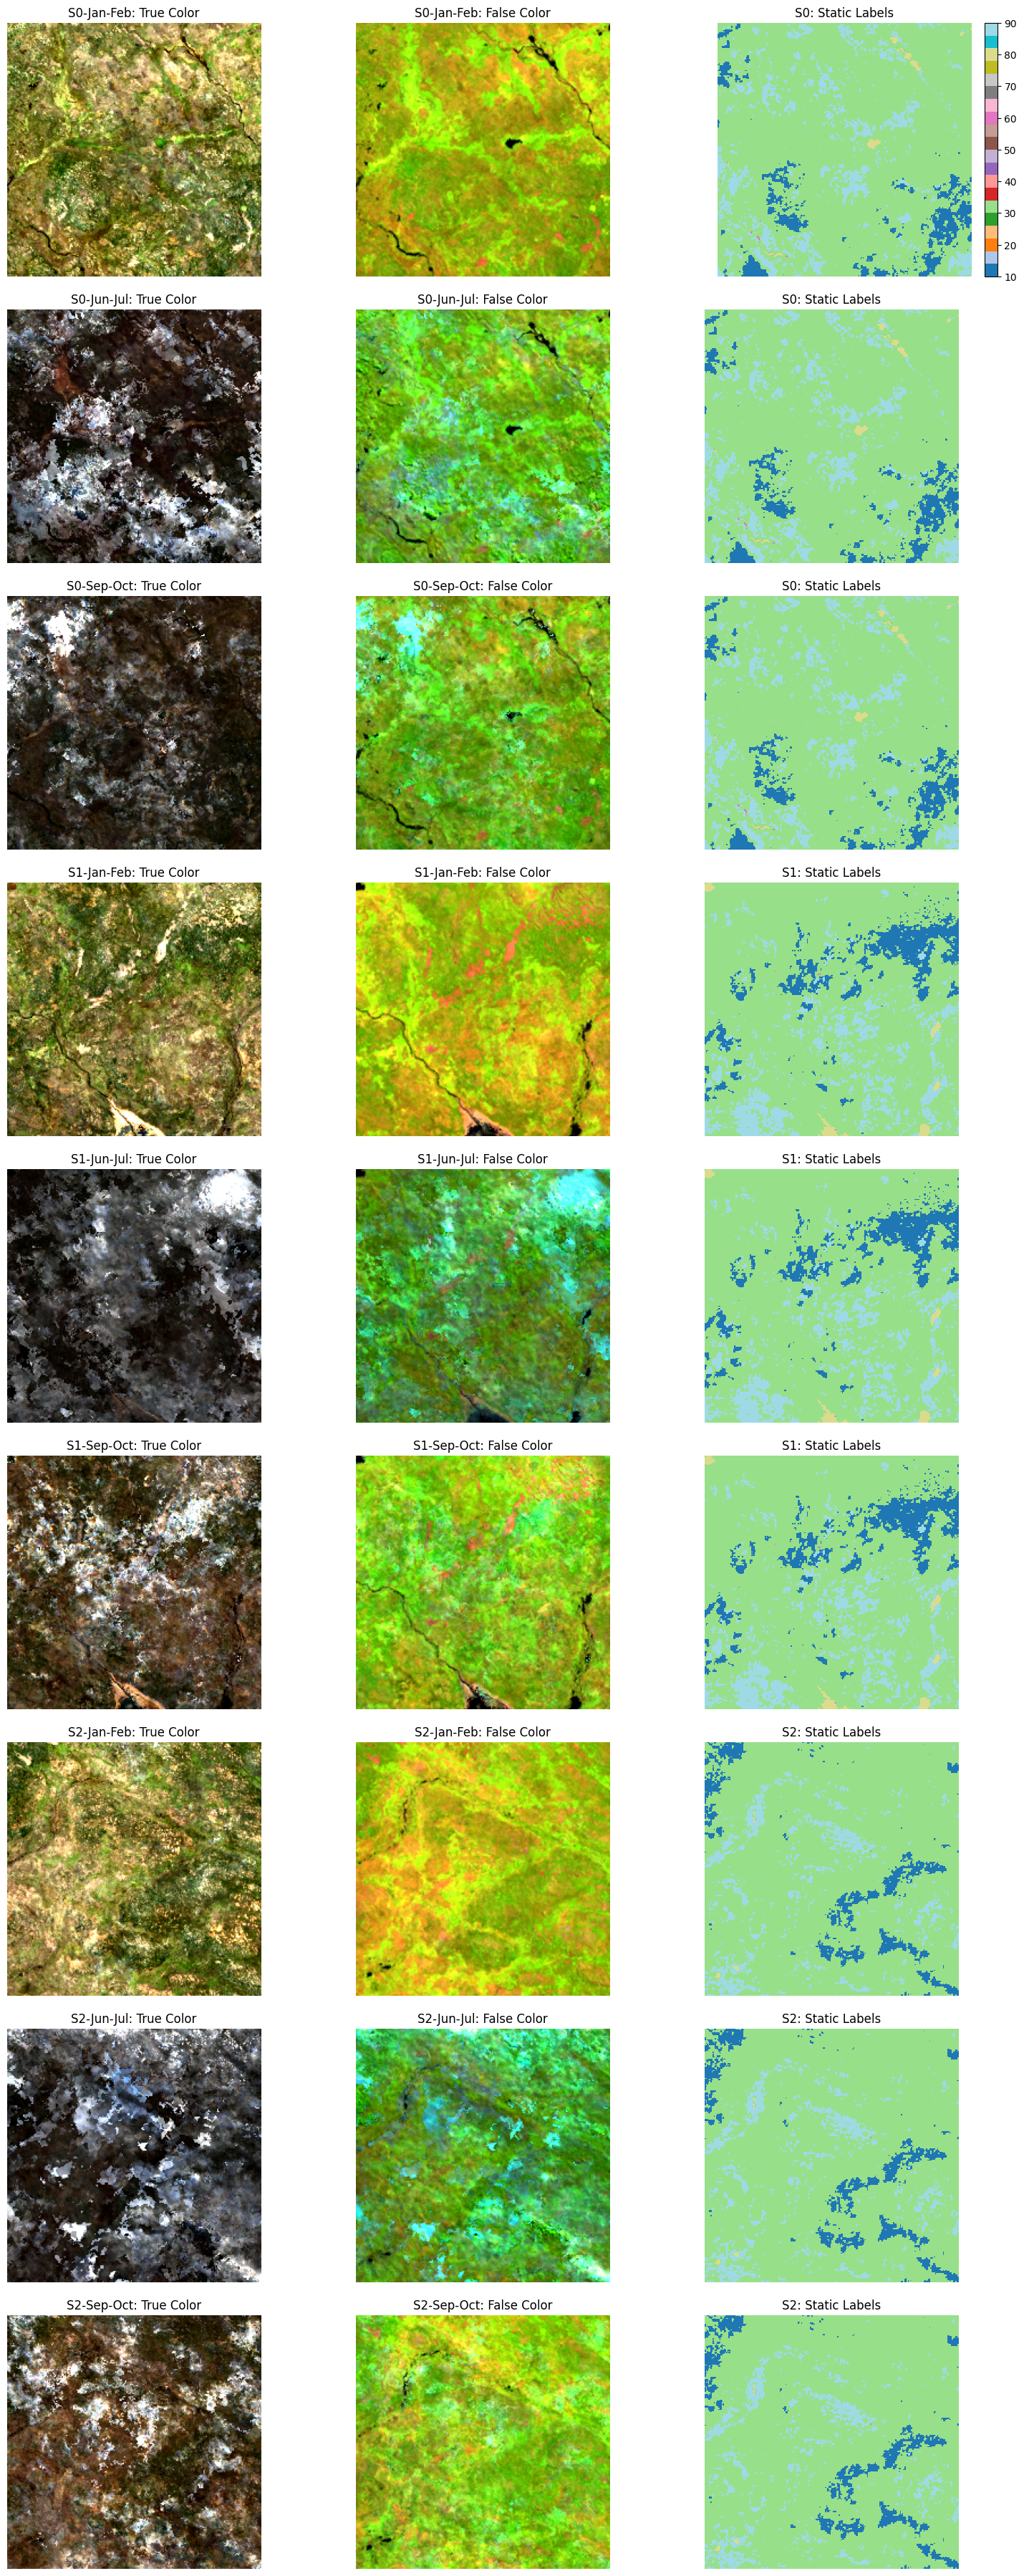

In [14]:
# Basic testing script to see that saving the data worked, TODO: use hvplot for better efficiency
import matplotlib.pyplot as plt
import s3fs
import dask.distributed

s3_zarr_path = s3_path_final # Ensure this variable is accessible/set

print(f"⏳ Verifying Saved Data at: {s3_zarr_path}")

# --- 1. Load Data ---
# Use Dask for loading to match the environment, although 'chunks={}' will load
# the metadata and index the chunks for all workers.
try:
    # Set up S3 access
    fs = s3fs.S3FileSystem()
    store = s3fs.S3Map(root=s3_zarr_path, s3=fs, check=False)
    
    # Open the multi-sample Zarr store. 'chunks={}' loads the full dataset chunks
    # lazily without combining them into a single dask chunk.
    ds = xr.open_dataset(store, engine='zarr', chunks={}) 
except Exception as e:
    print(f"⚠️ Error loading Zarr: {e}")
    raise

features = ds['features']
print(features)
labels = ds['labels']

num_samples = ds.sizes.get('sample')
n_time_steps = ds.sizes.get('time')

if num_samples is None or n_time_steps != 3:
    print("\n❌ CRITICAL ERROR: The loaded Zarr file still does NOT contain the 'sample' dimension or the correct 'time' size (3).")
    print("Please re-run the data generation pipeline to ensure the correct multi-sample Zarr is saved before proceeding.")
    # Exit or raise an exception to prevent training on bad data
    raise KeyError("Loaded Zarr file is structurally incorrect. Expected dimensions 'sample' and 'time' size 3.")

print(f"Dataset loaded. Dimensions:")
print(f"  Samples (N): {num_samples}")
print(f"  Time Steps (T): {n_time_steps}")
print(f"  Spatial (Y, X): {features.sizes['y']}, {features.sizes['x']}")

# --- 2. Config & Helpers ---
# Band names are now coordinates thanks to the saving logic
band_names = ds.attrs["bands"] # Retrieve band names from dataset attributes
print(f"  Bands: {band_names}")

def get_rgb(data_array, bands_list):
    """
    Extracts bands for RGB from a DataArray, assuming the order (B, T, Y, X).
    """
    stack = []
    
    # 1. Extraction (Still the same, but now operating on the first dim B)
    for b in bands_list:
        # Select band across all time steps (Output shape: (T, Y, X))
        band_data = data_array.sel(band=b)  
        stack.append(band_data)
        
    # Stack along a new 'color' dimension. Output shape: (Color, T, Y, X)
    img = xr.concat(stack, dim="color").values.astype('float32')

    # 2. DN Scaling Correction (Scale from uint16 DNs to 0.0-1.0 float range)
    img = img / 10000.0
    img = np.nan_to_num(img, nan=0.0)
    
    # 3. Final Transpose: (Color, T, Y, X) -> (T, Y, X, Color) for plotting
    # Plotting requires (Time, Height, Width, Color)
    img = np.transpose(img, (1, 2, 3, 0)) 
    
    # Check if all images are empty (all zeros)
    if img.max() == 0:
        return None 
        
    # Contrast Stretch - apply stretching to each time step independently
    # The loop is now simpler as 'img' is already (T, Y, X, Color)
    for t in range(img.shape[0]):
        time_slice = img[t, :, :, :]
        valid_pixels = time_slice[time_slice > 0]
        
        if valid_pixels.size > 0:
            p2, p98 = np.percentile(valid_pixels, (2, 98))
            if p98 > p2:
                img[t, :, :, :] = (time_slice - p2) / (p98 - p2)
                        
    return np.clip(img, 0, 1)

# --- 3. Dynamic Plotting Loop ---

# Iterate over SAMPLES, not time steps.
rows = num_samples * n_time_steps 
cols = 3 # RGB, False Color, Labels

plt.figure(figsize=(15, 4 * rows))

plot_idx = 1
season_names = ["Jan-Feb", "Jun-Jul", "Sep-Oct"] # Names from seasonal_windows

for s in range(3):
    # Select a single sample and compute its features and label.
    # .compute() here will read data off S3, potentially distributively if
    # the dask client is still running, which is appropriate for verification.
    sample_features = features.isel(sample=s).compute()
    sample_label = labels.isel(sample=s).compute()
    # Since the labels are static per sample (no 'time' dimension), we plot it once
    label_np = sample_label.values
    
    # 🚨 DEBUGGING STEP: Print unique values
    unique_vals = np.unique(label_np)
    print(f"DEBUG: Sample {s} unique label values: {unique_vals}")
    # ----------------------------------------
    # Check for valid data across all time steps in this sample
    # (Checking the max of the entire sample array is a quick check)
    if sample_features.values.max() == 0:
        print(f"⚠️ Sample {s} appears empty (all zeros). Skipping.")
        continue

    # Process all time steps for this sample
    print(f"Processing Sample {s}...")

    # Generate Images for all time steps at once
    # rgb_stack: (T, Y, X, Color)
    rgb_stack = get_rgb(sample_features, ['red', 'green', 'blue'])
    fc_stack  = get_rgb(sample_features, ['swir1', 'nir', 'red'])

    if rgb_stack is None:
        print(f"⚠️ Skipping Sample {s}: RGB stack failed.")
        continue
    
    # Since the labels are static per sample (no 'time' dimension), we plot it once
    label_np = sample_label.values
    
    for t in range(n_time_steps):
        time_name = season_names[t] if t < len(season_names) else f"Time {t}"
        
        # Plot RGB
        ax1 = plt.subplot(rows, cols, plot_idx)
        ax1.imshow(rgb_stack[t, :, :, :])
        ax1.set_title(f"S{s}-{time_name}: True Color")
        ax1.axis('off')
        plot_idx += 1

        # Plot False Color
        ax2 = plt.subplot(rows, cols, plot_idx)
        ax2.imshow(fc_stack[t, :, :, :])
        ax2.set_title(f"S{s}-{time_name}: False Color")
        ax2.axis('off')
        plot_idx += 1

        # Plot Labels (Only plot on the last column, which should be the same for all time steps)
        ax3 = plt.subplot(rows, cols, plot_idx)
        
        # The labels (WorldCover) are 2D (Y, X), but we repeat the plot for each time step for alignment.
        # Mask out background (0) and nodata (255) for better visualization.
        masked_lbl = np.ma.masked_where(label_np == 255, label_np)
        
        # We need a new colormap instance for consistency if plotting multiple times
        im = ax3.imshow(masked_lbl, cmap='tab20', interpolation='nearest')
        
        # Add colorbar only once for the entire set of label plots (e.g., first time step of the first sample)
        if s == 0 and t == 0: 
            plt.colorbar(im, fraction=0.046, pad=0.04)
            
        # Title only needs to be "Labels" once, or be more specific
        ax3.set_title(f"S{s}: Static Labels")
        ax3.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.show()

In [ ]:
client.close()
cluster.shutdown()